In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import talib
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr, spearmanr
from statsmodels.regression.rolling import RollingOLS


import datetime
import time
import os
import pytz
import json
import csv

from pprint import pprint



In [2]:
# GLOBAL SETTINGS

# Data directories
#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
coin_dataDir = 'DATA/COMBINEDDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/'
model_dataDir = 'DATA/MODELDATA/'
riskFactor_dataDir = 'DATA/RISKFACTORSDATA/'



isdir = os.path.isdir(model_dataDir)

# Date ranges
START = 2019
END = 2022

MONTH = 30
YEAR = 12 * MONTH

# Helpers
idx = pd.IndexSlice
sns.set_style('whitegrid')

# END GLOBAL SETTINGS

In [3]:
# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)
print('Initial Base Data:'.upper())
print(cpool_mdf.info())


ohlcv = ['Open','High','Low','Close','Volume']
prices_mdf = (cpool_mdf
              .loc[idx[str(START):str(END), :], ohlcv]
              .swaplevel()
              .sort_index())

# want at least X years of data
yr = 3
min_obs = yr * YEAR

# have this much per ticker
nobs = prices_mdf.groupby(level='Coin').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices_mdf = prices_mdf.loc[idx[keep, :], :]
print(f"After dropping coins with less than {yr} years of data".upper())
print(prices_mdf.info())

INITIAL BASE DATA:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8030 entries, (Timestamp('2018-08-24 00:00:00'), 'binancecoin') to (Timestamp('2022-02-06 00:00:00'), 'uniswap')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        8030 non-null   float64
 1   High        8030 non-null   float64
 2   Low         8030 non-null   float64
 3   Close       8030 non-null   float64
 4   Volume      8030 non-null   float64
 5   Market Cap  8030 non-null   float64
dtypes: float64(6)
memory usage: 442.5+ KB
None
AFTER DROPPING COINS WITH LESS THAN 3 YEARS OF DATA
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5665 entries, ('binancecoin', Timestamp('2019-01-01 00:00:00')) to ('ripple', Timestamp('2022-02-06 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5665 non-null   float64
 1   High    5665 non-null   float64
 2   Low     566

In [4]:
# Compute Technical Analysis Indicators to be use as momentum alpha factors (The Features)

# Relative Strength Index (RSI)
prices_mdf['RSI'] = prices_mdf.groupby(level='Coin').Close.apply(talib.RSI)

# Bollinger Bands
def compute_bb(close):
    high, mid, low = talib.BBANDS(close, timeperiod=20)
    return pd.DataFrame({'BB_high': high, 'BB_low': low}, index=close.index)

prices_mdf = (prices_mdf.join(prices_mdf
                      .groupby(level='Coin')
                      .Close
                      .apply(compute_bb)))

# Average True Range (ATR)
def compute_atr(coin_data):
    df = talib.ATR(coin_data.High, coin_data.Low,
             coin_data.Close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices_mdf['ATR'] = (prices_mdf.groupby('Coin', group_keys=False)
                 .apply(compute_atr))

# Moving Average Convergence Divergence (MACD)
def compute_macd(close):
    macd = talib.MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices_mdf['MACD'] = (prices_mdf
                  .groupby('Coin', group_keys=False)
                  .Close
                  .apply(compute_macd))


# Stochastic Oscillator (STOCH)
def compute_stoch(coin_data):
    slowk, slowd = talib.STOCH(coin_data.High,
                         coin_data.Low,
                         coin_data.Close,
                         fastk_period=14,
                         slowk_period=3,
                         slowk_matype=0,
                         slowd_period=3,
                         slowd_matype=0)

    return slowd/slowk

prices_mdf['STOCH'] = (prices_mdf
                       .groupby('Coin', group_keys=False)
                       .apply(compute_stoch))

# Average Directional Index (ADX)
def compute_adx(coin_data):
    real = talib.ADX(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf['ADX'] = (prices_mdf
                     .groupby('Coin', group_keys=False)
                     .apply(compute_adx))


#Plus/Minus Directional Index
def compute_diplus(coin_data):
    real = talib.PLUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

def compute_diminus(coin_data):
    real = talib.MINUS_DI(coin_data.High,
                     coin_data.Low,
                     coin_data.Close,
                     timeperiod=14)

    return real

prices_mdf["DI_PLUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diplus))
prices_mdf["DI_MINUS"] = (prices_mdf.groupby('Coin', group_keys=False).apply(compute_diminus))

# Compute lagged returns and Winsorize
#lags = [1, 7, 14, 30, 60, 90]
lags = [1, 7, 14, 30]

q = 0.0001

for lag in lags:
    prices_mdf[f'return_{lag}d'] = (prices_mdf.groupby(level='Coin').Close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )
# Shift lagged returns
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 7, 14, 30]:
#    for lag in [1, 7, 14, 30, 60, 90]:

        prices_mdf[f'return_{lag}d_lag{t}'] = (prices_mdf.groupby(level='Coin')
                                           [f'return_{lag}d'].shift(t * lag))

# Generate target forward returns
#for t in [1, 7, 14, 30, 60, 90]:
for t in [1, 7, 14, 30]:

    prices_mdf[f'target_{t}d'] = prices_mdf.groupby(level='Coin')[f'return_{t}d'].shift(-t)

# Create dummy time variables. USe drop first to avoid creating multicollinearity.
prices_mdf['year'] = prices_mdf.index.get_level_values('Dates').year
prices_mdf['month'] = prices_mdf.index.get_level_values('Dates').month

prices_mdf = pd.get_dummies(prices_mdf,
                        columns=['year', 'month'],
                        prefix=['year', 'month'],
                        prefix_sep=['_', '_'],
                        drop_first=True)


# Read in PCA Risk Factors
risk_factors_df = pd.read_csv(riskFactor_dataDir + 'PCA_Risk_Factors.csv')
risk_factors_df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
risk_factors_df['Dates'] = risk_factors_df['Dates'].astype('datetime64')
risk_factors_df = risk_factors_df.set_index('Dates')
risk_factors_df.drop(risk_factors_df.index[-1], inplace=True)

# Combine them with daily returns
#daily_returns = prices_mdf.loc[:, 'return_1d':'return_90d']
daily_returns = prices_mdf.loc[:, 'return_1d':'return_30d']
factor_betas = daily_returns.join(risk_factors_df).sort_index()

# Get rid of the extra returns
del factor_betas['return_7d']
del factor_betas['return_14d']
del factor_betas['return_30d']
#del factor_betas['return_60d']
#del factor_betas['return_90d']

# Compute the factor Betas with Rolling OLS Regression on the PCA Principal Componenets
T = 30
betas = (factor_betas.groupby(level='Coin',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1d,
                                     exog=sm.add_constant(x.drop('return_1d', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))


factors = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3',
           'Principal Component 4']

# Impute missing Betas
betas = betas.loc[:, factors] = betas.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Factos Betas:".upper())
print(betas.describe().join(betas.sum(1).describe().to_frame('total')))

# Combine the Factor Betas with the rest of the model
prices_mdf = (prices_mdf
        .join(betas
              .groupby(level='Coin')
              .shift()))

# Immpute the missing factor betas to fill things out
prices_mdf.loc[:, factors] = prices_mdf.groupby('Coin')[factors].apply(lambda x: x.fillna(x.mean()))
print("Features so far".upper())
print(prices_mdf.columns)

FACTOS BETAS:
       Principal Component 1  Principal Component 2  Principal Component 3  \
count            5665.000000            5665.000000            5665.000000   
mean                0.489329              -0.018095              -0.063773   
std                 0.109362               0.511752               0.492683   
min                 0.189366              -1.658799              -1.525694   
25%                 0.443659              -0.237460              -0.410271   
50%                 0.470865              -0.010068              -0.207133   
75%                 0.539254               0.250178              -0.007420   
max                 0.987456               1.832078               1.408900   

       Principal Component 4        total  
count            5665.000000  5665.000000  
mean                0.008602     0.416064  
std                 0.515753     0.910228  
min                -1.084314    -1.697431  
25%                -0.480111    -0.343154  
50%                

In [49]:
prices_mdf

RSI   BB_high    BB_low       ATR      MACD  \
Coin        Dates                                                           
binancecoin 2019-06-30  45.442216  0.142460  0.035058 -0.578680 -0.114619   
            2019-07-01  45.176334  0.145549  0.037643 -0.577813 -0.127904   
            2019-07-02  44.553065  0.150548  0.041157 -0.578407 -0.139517   
            2019-07-03  45.871391  0.143779  0.056104 -0.582421 -0.147341   
            2019-07-04  46.680201  0.138860  0.058344 -0.581524 -0.152701   
...                           ...       ...       ...       ...       ...   
ripple      2022-01-03  41.975517  0.147442  0.073745  0.263008 -0.472492   
            2022-01-04  42.069388  0.146929  0.073948  0.231493 -0.490976   
            2022-01-05  33.575617  0.214867  0.000764  0.298372 -0.628427   
            2022-01-06  32.299746  0.230178  0.000961  0.296916 -0.752770   
            2022-01-07  37.296704  0.210859  0.047563  0.274116 -0.796883   

                           STOCH        ADX    DI_PLUS   DI_MINUS  return_1d  \
Coin        Dates                                                              
binancecoin 2019-06-30  1.304120  16.915518  23.350523  25.923572  -0.064498   
            2019-07-01  1.375530  16.137838  21.539481  24.302860  -0.002658   
            2019-07-02  1.716978  15.991223  20.091781  26.679641  -0.005917   
            2019-07-03  0.956775  15.622663  20.563099  25.558729   0.009757   
            2019-07-04  0.734482  14.639044  24.455742  23.566368   0.005725   
...                          ...        ...        ...        ...        ...   
ripple      2022-01-03  1.112944  18.817726  20.146504  29.070071  -0.018572   
            2022-01-04  1.137454  18.969251  19.227762  29.412605   0.000626   
            2022-01-05  1.616836  20.137533  16.859288  35.276273  -0.090881   
            2022-01-06  2.182057  21.418501  15.674079  34.945503  -0.018161   
            2022-01-07  1.294469  22.607971  14.836733  33.078633   0.036020   

                        ...  month_7  month_8  month_9  month_10  month_11  \
Coin        Dates       ...                                                  
binancecoin 2019-06-30  ...        0        0        0         0         0   
            2019-07-01  ...        1        0        0         0         0   
            2019-07-02  ...        1        0        0         0         0   
            2019-07-03  ...        1        0        0         0         0   
            2019-07-04  ...        1        0        0         0         0   
...                     ...      ...      ...      ...       ...       ...   
ripple      2022-01-03  ...        0        0        0         0         0   
            2022-01-04  ...        0        0        0         0         0   
            2022-01-05  ...        0        0        0         0         0   
            2022-01-06  ...        0        0        0         0         0   
            2022-01-07  ...        0        0        0         0         0   

                        month_12  Principal Component 1  \
Coin        Dates                                         
binancecoin 2019-06-30         0               0.443490   
            2019-07-01         0               0.444030   
            2019-07-02         0               0.443975   
            2019-07-03         0               0.443904   
            2019-07-04         0               0.443564   
...                          ...                    ...   
ripple      2022-01-03         0               0.456326   
            2022-01-04         0               0.455971   
            2022-01-05         0               0.455906   
            2022-01-06         0               0.455856   
            2022-01-07         0               0.455674   

                        Principal Component 2  Principal Component 3  \
Coin        Dates                                                      
binancecoin 2019-06-30               0.704416              -

In [5]:
# Save the model data
if isdir == False:
    os.makedirs(model_dataDir)
    print("Directory '% s' created" % model_dataDir)
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")

else:
    prices_mdf.to_csv(f'{model_dataDir}ModelData.csv')
    prices_mdf.to_hdf(f'{model_dataDir}model_data.h5', 'model_data')
    print(f"The model data has been saved to {model_dataDir} as a MultiIndex dataframe")



The model data has been saved to DATA/MODELDATA/ as a MultiIndex dataframe


Coins with Unique Values:
5


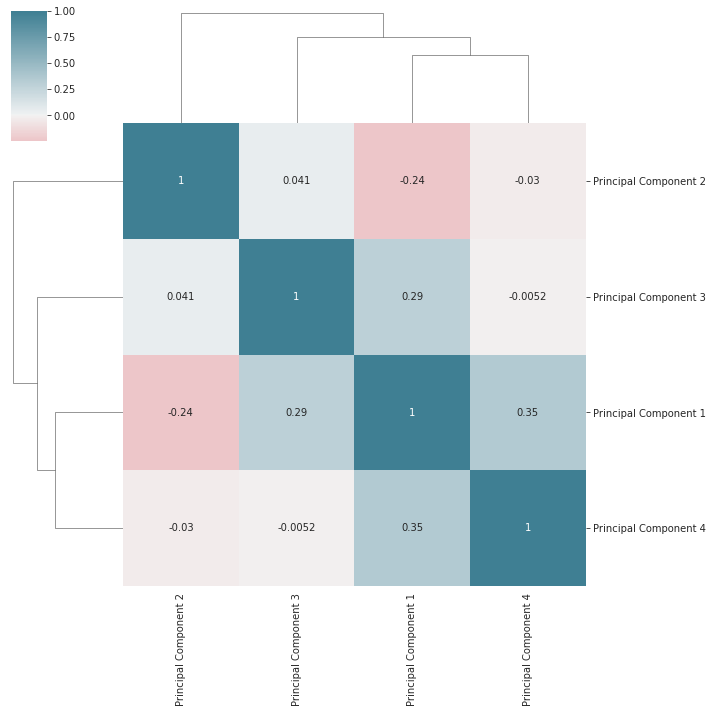

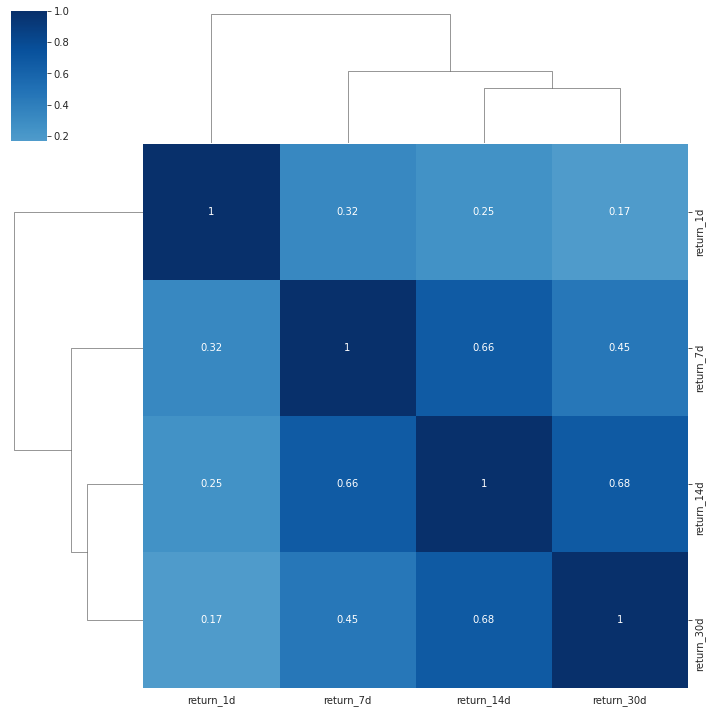

In [6]:
# DATASET INSIGHTS AND VISUALIZATION PLOTS

# Plot correlation custermap of the Betas
cmap = sns.diverging_palette(10, 220, as_cmap=True)
beta_cmap = sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0)

# Correlation Cluster map of the Returns
#returns = prices_mdf.loc[:, 'return_1d':"return_90d"]
returns = prices_mdf.loc[:, 'return_1d':"return_30d"]
clusterMap = sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap='Blues')
print('Coins with Unique Values:')
print(returns.index.get_level_values('Coin').nunique())

In [7]:
# Check return distributions

#sns_distPlot = sns.distplot(returns['return_90d'])
#fig = sns_distPlot.get_figure()
#sns.despine()

In [8]:
#sns_distPlot = sns.distplot(returns['return_60d'])
#fig = sns_distPlot.get_figure()
#sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


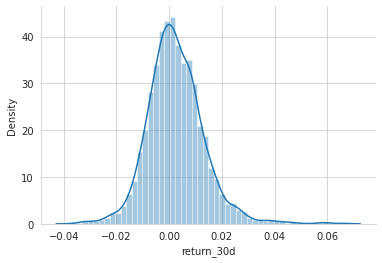

In [9]:
sns_distPlot = sns.distplot(returns['return_30d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


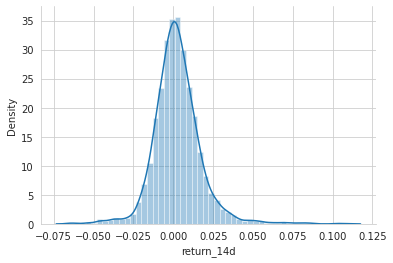

In [10]:
sns_distPlot = sns.distplot(returns['return_14d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


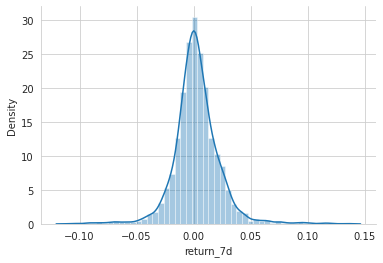

In [11]:
sns_distPlot = sns.distplot(returns['return_7d'])
fig = sns_distPlot.get_figure()
sns.despine()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


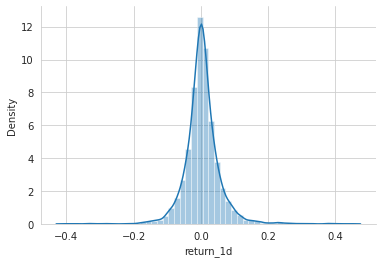

In [12]:
sns_distPlot = sns.distplot(returns['return_1d'])
fig = sns_distPlot.get_figure()
sns.despine()

Daily Returns Spearman
-8.80% (0.00%)


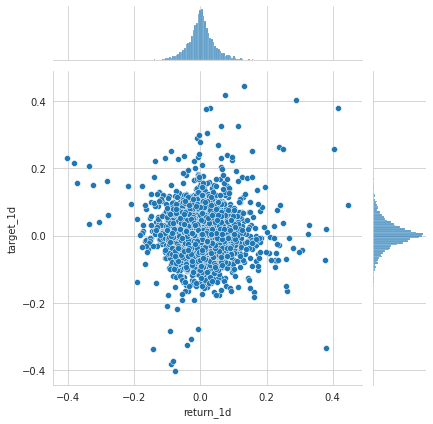

In [13]:
# Spearman Ranks and scatter plots for factors
target = 'target_7d'
price_copy = prices_mdf.copy()

# Daily Returns
daily_target = "target_1d"
metric = 'return_1d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Daily Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')


Weekly Returns Spearman
3.63% (0.67%)


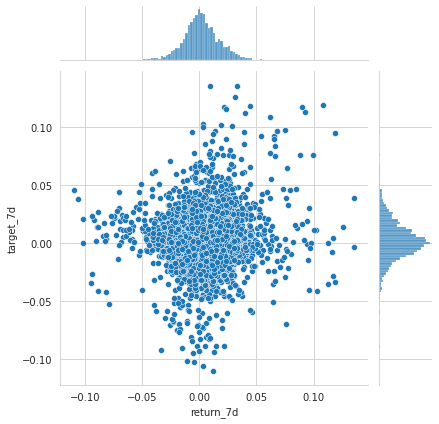

In [14]:
# Weekly Returns
daily_target = "target_7d"
metric = 'return_7d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Bi-Weekly Returns Spearman
13.16% (0.00%)


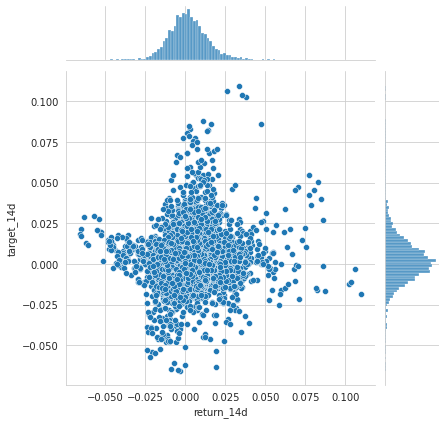

In [15]:
# Bi-Weekly Returns
daily_target = "target_14d"
metric = 'return_14d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Bi-Weekly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

Monthly Returns Spearman
7.08% (0.00%)


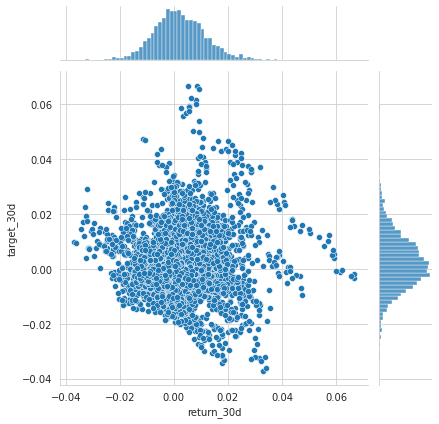

In [18]:
# Monthly Returns
daily_target = "target_30d"
metric = 'return_30d'
j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
df = price_copy[[metric, daily_target]].dropna()
r, p = spearmanr(df[metric], df[daily_target])
print("Monthly Returns Spearman")
print(f'{r:,.2%} ({p:.2%})')

In [19]:
# Bi-Monthly Returns
#daily_target = "target_60d"
#metric = 'return_60d'
#j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
#df = price_copy[[metric, daily_target]].dropna()
#r, p = spearmanr(df[metric], df[daily_target])
#print("Bi-Monthly Returns Spearman")
#print(f'{r:,.2%} ({p:.2%})')

In [20]:
# Three Month Returns
#daily_target = "target_90d"
#metric = 'return_90d'
#j=sns.jointplot(x=metric, y=daily_target, data=price_copy)
#df = price_copy[[metric, daily_target]].dropna()
#r, p = spearmanr(df[metric], df[daily_target])
#print("Three Month Returns Spearman")
#print(f'{r:,.2%} ({p:.2%})')

Daily RETURNS FEATURE INFO
RSI Distributions
             count      mean       std       min       25%       50%       75%       max
rsi_signal                                                                              
(0, 30]      164.0  0.005040  0.016761 -0.066810 -0.000519  0.004706  0.013363  0.045421
(30, 70]    4769.0  0.001824  0.019218 -0.109725 -0.007763  0.001156  0.011273  0.135513
(70, 100]    627.0  0.008375  0.026692 -0.072761 -0.007351  0.003890  0.019348  0.135180
RSI Spearman
9.15% (0.00%)


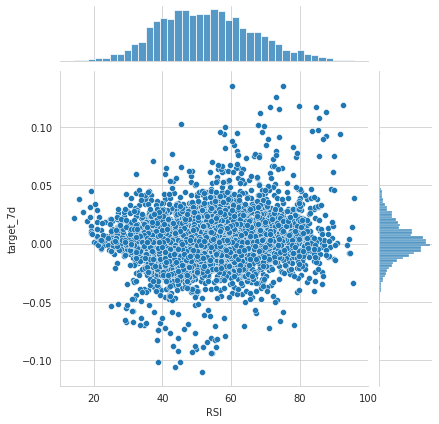

In [21]:
# Relative Strength Index (RSI)
print("Daily RETURNS FEATURE INFO")
price_copy.loc[:, 'rsi_signal'] = pd.cut(price_copy.RSI, bins=[0, 30, 70, 100])
print("RSI Distributions")
print(price_copy.groupby('rsi_signal')['target_7d'].describe().to_string())

metric = "RSI"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("RSI Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)


ADX FEATURE INFO
ADX Distributions
             count      mean       std       min       25%       50%       75%       max
adx_signal                                                                              
(0, 25]     2181.0  0.002203  0.019404 -0.101975 -0.007703  0.001123  0.011324  0.116878
(25, 50]    2975.0  0.003231  0.020567 -0.109725 -0.007056  0.002225  0.012785  0.135513
(50, 75]     339.0  0.002029  0.023736 -0.072761 -0.009413  0.000787  0.011367  0.118970
(75, 100]      0.0       NaN       NaN       NaN       NaN       NaN       NaN       NaN
ADX Spearman
4.14% (0.22%)


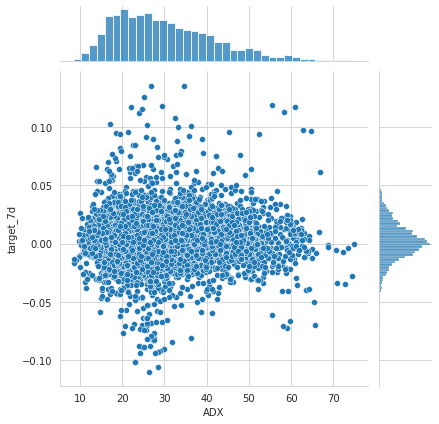

In [22]:
# Average Directional Moving Index (ADX)
print("ADX FEATURE INFO")
price_copy.loc[:, 'adx_signal'] = pd.cut(price_copy.ADX, bins=[0, 25, 50, 75, 100])
print("ADX Distributions")
print(price_copy.groupby('adx_signal')['target_7d'].describe().to_string())

metric = "ADX"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ADX Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)



DI Plus Spearman
6.70% (0.00%)


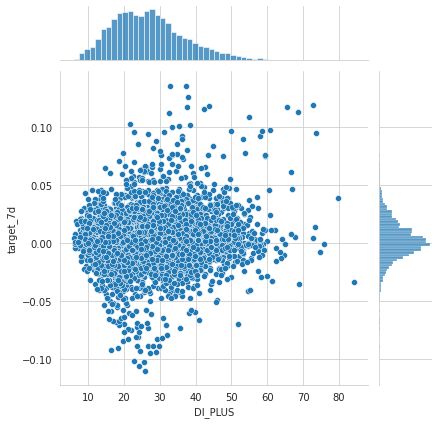

In [23]:
# Directional Indices (DM+/-)
metric = "DI_PLUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Plus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

DI Minus Spearman
-8.12% (0.00%)


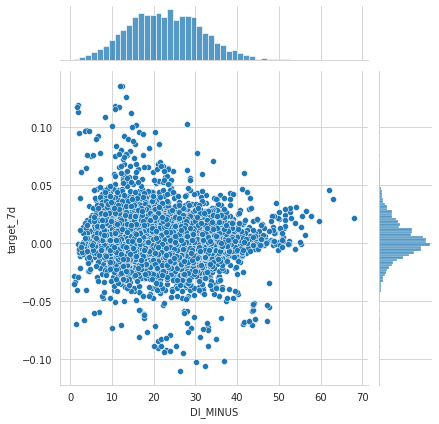

In [24]:
metric = "DI_MINUS"
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("DI Minus Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

Lower BB Spearman
0.76% (57.33%)


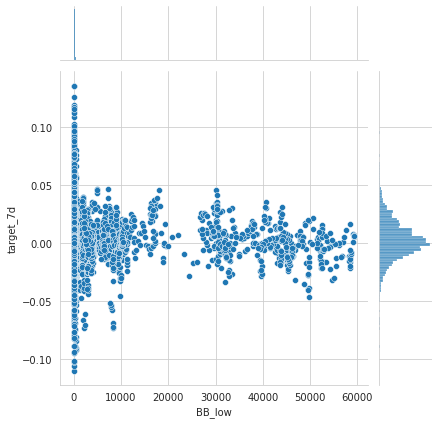

In [25]:
# Bollinger Bands
metric = 'BB_low'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Lower BB Spearman")
print(f'{r:,.2%} ({p:.2%})')


Upper BB Spearman
0.94% (48.62%)


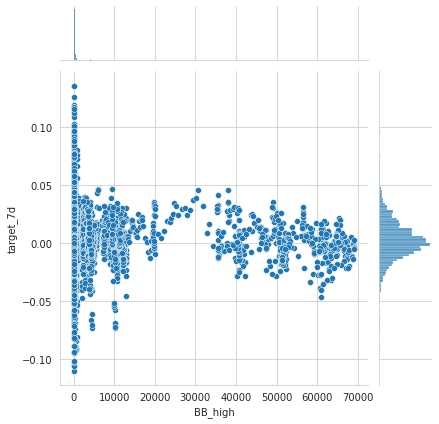

In [26]:
metric = 'BB_high'
df = price_copy[[metric, target]].dropna()
j=sns.jointplot(x=df[metric], y=df[target], data=df)
r, p = spearmanr(df[metric], df[target])
print("Upper BB Spearman")
print(f'{r:,.2%} ({p:.2%})')

ATR Spearman
-8.23% (0.00%)


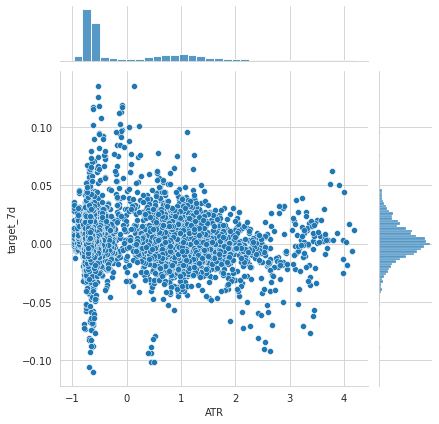

In [27]:
# Active True Range (ATR)
metric = 'ATR'
j=sns.jointplot(x=metric, y=target, data=price_copy)
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("ATR Spearman")
print(f'{r:,.2%} ({p:.2%})')

MACD Spearman
8.43% (0.00%)


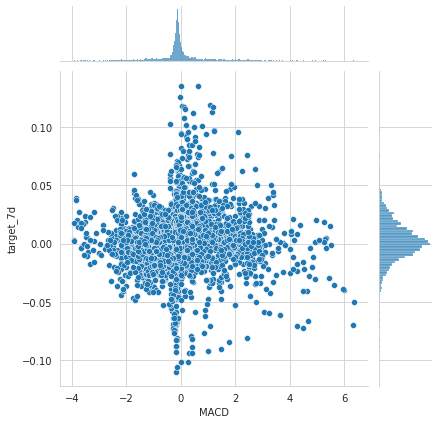

In [28]:
# Moving Average Convegeance Divergeance (MACD)
metric = 'MACD'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("MACD Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

STOCH Spearman
-0.58% (66.81%)


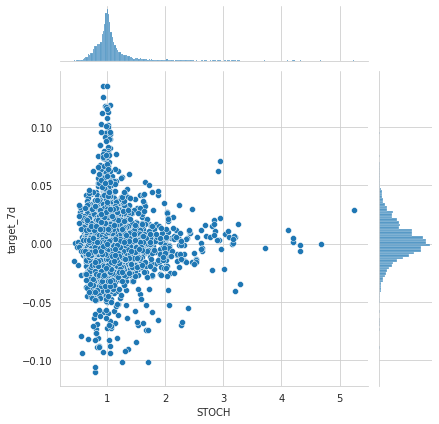

In [29]:
# Stochastic Oscillator
metric = 'STOCH'
df = price_copy[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print("STOCH Spearman")
print(f'{r:,.2%} ({p:.2%})')
j=sns.jointplot(x=df[metric], y=df[target], data=df)

In [30]:
# Distribution plots and statistics
print("RETURNS PERCENTILES")
returns = prices_mdf.groupby(level='Coin').Close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
print(returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles'))

RETURNS PERCENTILES
        percentiles
std        0.052355
min       -0.429773
0.01%     -0.402203
0.1%      -0.313785
1%        -0.129778
50%        0.001911
99%        0.163489
99.9%      0.344609
99.99%     0.446604
max        0.485204


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


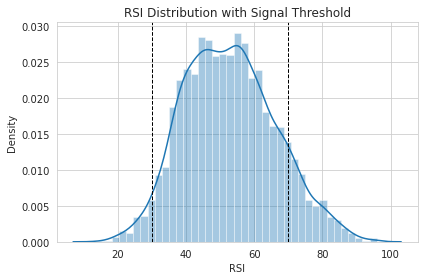

In [31]:
# RSI distplot
RSI_ax = sns.distplot(prices_mdf.RSI.dropna())
RSI_ax.axvline(30, ls='--', lw=1, c='k')
RSI_ax.axvline(70, ls='--', lw=1, c='k')
RSI_ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


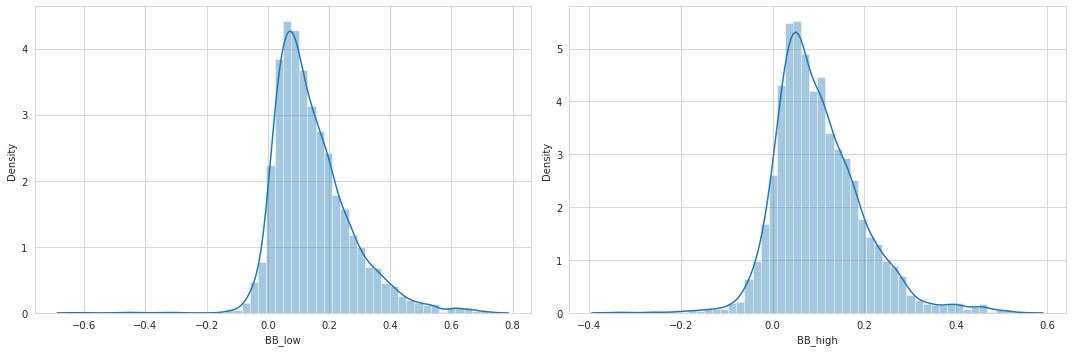

In [32]:
# Bollinger Bands distplot
prices_mdf['BB_high'] = prices_mdf.BB_high.sub(prices_mdf.Close).div(prices_mdf.BB_high).apply(np.log1p)
prices_mdf['BB_low'] = prices_mdf.Close.sub(prices_mdf.BB_low).div(prices_mdf.Close).apply(np.log1p)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.BB_low.dropna(), ax=axes[0])
sns.distplot(prices_mdf.BB_high.dropna(), ax=axes[1])
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


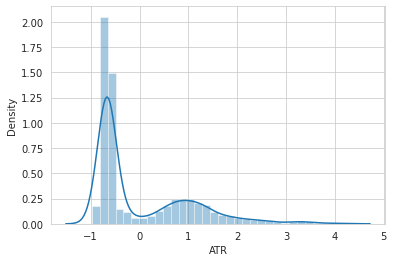

In [33]:
# Average True Range
atr_plot = sns.distplot(prices_mdf.ATR.dropna())
fig = atr_plot.get_figure()

MACD Percentiles
count    5,500.0
mean        -0.0
std          1.0
min         -3.9
0.1%        -3.8
1%          -2.5
2%          -2.2
3%          -1.9
4%          -1.7
5%          -1.5
50%         -0.1
95%          2.0
96%          2.2
97%          2.5
98%          2.8
99%          3.3
99.9%        5.5
max          6.4
Name: MACD, dtype: object


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


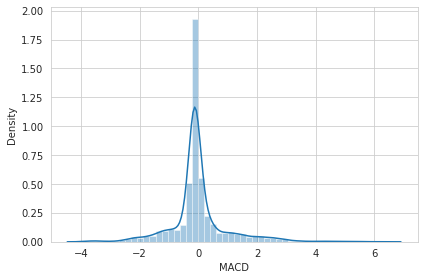

In [34]:
# MACD distribution
print("MACD Percentiles")
print(prices_mdf
      .MACD
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))

MACD_dist = sns.distplot(prices_mdf.MACD.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'ADX Distribution with Signal Threshold')

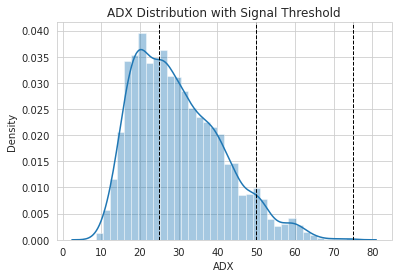

In [35]:
# ADX distribution plot
ADX_dist = sns.distplot(prices_mdf.ADX.dropna())
ADX_dist.axvline(25, ls='--', lw=1, c='k')
ADX_dist.axvline(50, ls='--', lw=1, c='k')
ADX_dist.axvline(75, ls='--', lw=1, c='k')
ADX_dist.set_title('ADX Distribution with Signal Threshold')

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


STOCH percentiles
count    5,580.0
mean         1.1
std          0.3
min          0.4
0.1%         0.5
1%           0.6
2%           0.7
3%           0.7
4%           0.7
5%           0.7
50%          1.0
95%          1.6
96%          1.7
97%          1.8
98%          2.0
99%          2.3
99.9%        4.1
max          5.3
Name: STOCH, dtype: object


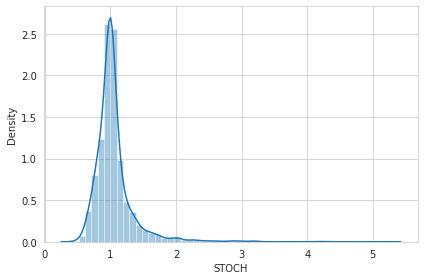

In [36]:
# Stochastic Oscillator distplot
print("STOCH percentiles")
print(prices_mdf
      .STOCH
      .describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999])
      .apply(lambda x: f'{x:,.1f}'))



STOCH_ax = sns.distplot(prices_mdf.STOCH.dropna())
plt.tight_layout()

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


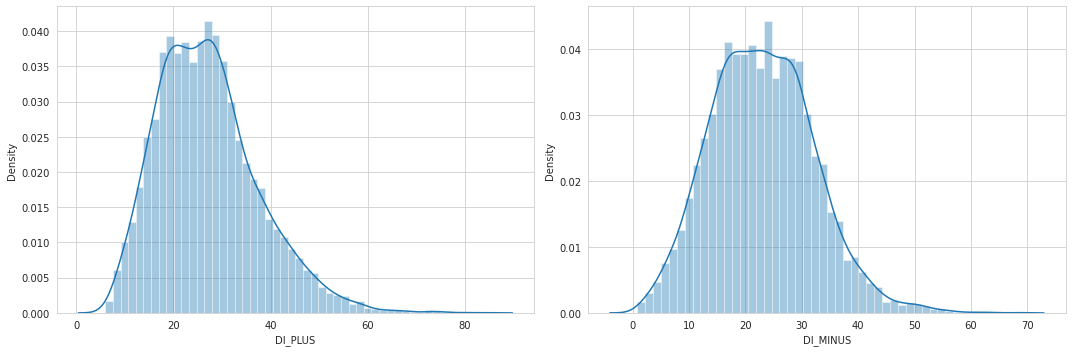

In [37]:
# Directional Indicators (DI +/-)
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices_mdf.DI_PLUS.dropna(), ax=axes[0])
sns.distplot(prices_mdf.DI_MINUS.dropna(), ax=axes[1])
plt.tight_layout()

In [38]:
prices_mdf = (prices_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High', 'Volume'], axis=1))

In [39]:
# Mutual Information of the Data
#target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]
target_labels = [f'target_{i}d' for i in [1,7,14,30]]
targets = prices_mdf.dropna().loc[:, target_labels]

features = prices_mdf.dropna().drop(labels=target_labels, axis=1)
#print(features.columns)
cat_cols = ['year_2021','year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [40]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [41]:
mutual_info.sum()

target_1d     0.139325
target_7d     0.374522
target_14d    0.575866
target_30d    0.776082
dtype: float64

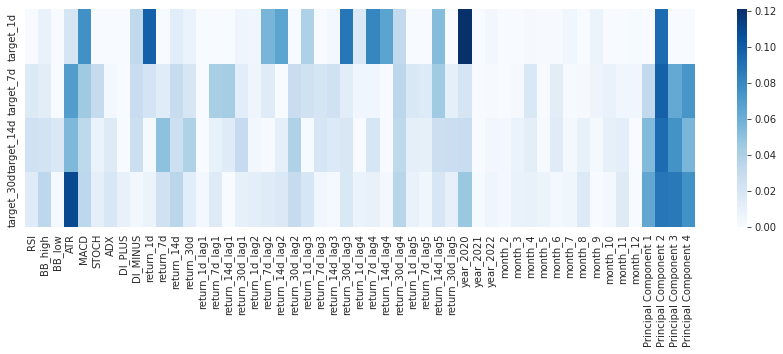

In [42]:
# Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

In [43]:
dummy_data = pd.get_dummies(prices_mdf,
                            columns=['year_2021', 'year_2022', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4615 entries, ('binancecoin', Timestamp('2019-06-30 00:00:00')) to ('ripple', Timestamp('2022-01-07 00:00:00'))
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RSI                    4615 non-null   float64
 1   BB_high                4615 non-null   float64
 2   BB_low                 4615 non-null   float64
 3   ATR                    4615 non-null   float64
 4   MACD                   4615 non-null   float64
 5   STOCH                  4615 non-null   float64
 6   ADX                    4615 non-null   float64
 7   DI_PLUS                4615 non-null   float64
 8   DI_MINUS               4615 non-null   float64
 9   return_1d              4615 non-null   float64
 10  return_7d              4615 non-null   float64
 11  return_14d             4615 non-null   float64
 12  return_30d             4615 non-null   float64
 13  return_1d_lag1      

In [45]:
# Dummy Data
#target_labels = [f'target_{i}d' for i in [1,7,14,30,60,90]]
target_labels = [f'target_{i}d' for i in [1,7,14,30]]

dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [46]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [47]:
mutual_info_dummies.sum()

target_1d     0.142208
target_7d     0.397192
target_14d    0.622608
target_30d    0.836142
dtype: float64

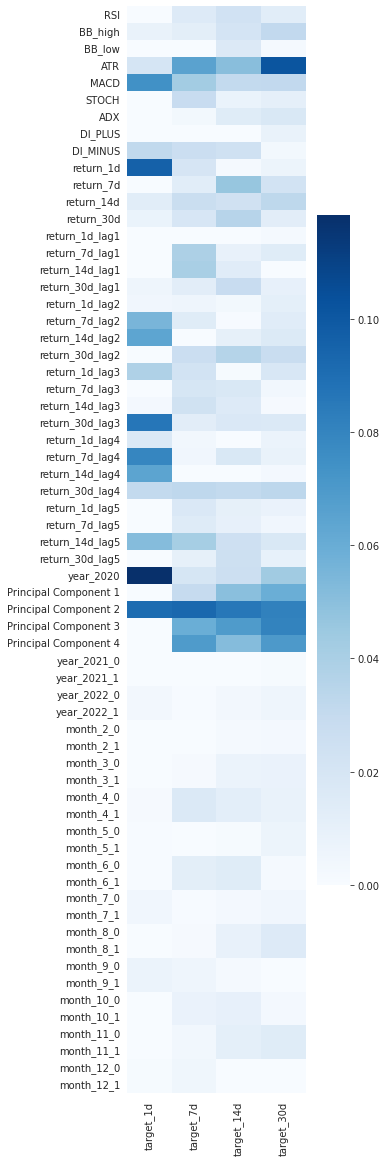

In [48]:
# Dummy Normalized Mutual Information(MI) Heatmap
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');